<a href="https://colab.research.google.com/github/virtualms/LunarLander-DQNs/blob/main/LunarLander_DQNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A comparison between 5 DQN variants on LunarLander-v2 environment**

The aim of this project is to experiment some DQN variants on [LunarLander-v2](https://github.com/openai/gym/wiki/Leaderboard#lunarlander-v2) environment, offered by [gym.openai](https://gym.openai.com/). In particular, the variants that will be implemented and compared (refer also to the report of the project) are:
* [DQN](https://arxiv.org/abs/1312.5602)
* [DQN with target network (Fixed Q-Targets)](https://www.nature.com/articles/nature14236)
* [Double DQN (DDQN)](https://arxiv.org/abs/1509.06461)
* [Dueling DQN](https://arxiv.org/abs/1511.06581)
* [Dueling Double DQN (D3QN)](https://ieeexplore.ieee.org/document/8483478)

In all the reported versions, an experience replay was implemented. For the project, I was also inspired by the work done in the [Rainbow paper](https://arxiv.org/abs/1710.02298) by DeepMind.

**Setup the environment**

First of all, we will start installing the needed dependencies to run the code on Colab environment.

In [ ]:
!(apt update && apt install xvfb ffmpeg python-opengl -y) > /dev/null 2>&1
!pip install gym-notebook-wrapper > /dev/null 2>&1
!pip3 install box2d-py > /dev/null 2>&1
!pip install gym[Box2D] > /dev/null 2>&1

Then we perform the import of the needed libraries and we check if we are running tf/keras on GPU.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import gym
import gnwrapper

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, Flatten, Dense, Input, InputLayer
from tensorflow.keras.models import Model
from keras.optimizers import Adam

import random
import pandas as pd
import numpy as np
from collections import deque
import time
import random

#check tf on GPU
#https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

#debug mode, what runs on gpu
#tf.debugging.set_log_device_placement(True)

#explicit GPU for keras
#config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 } ) 
#sess = tf.compat.v1.Session(config=config) 
#tf.compat.v1.keras.backend.set_session(sess)

GPUs Available:  1
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



# **Inspecting gym**

**Environment**

In [ ]:
ENVIRONMENT = 'LunarLander-v2'
PATH='/content/media/LunarLander-v2'

In [ ]:
env = gnwrapper.Monitor(gym.make(ENVIRONMENT), PATH)

Setting all the seeds for deterministic results.

In [ ]:
seed = 42

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

#https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Now we inspect "LunarLander" environment. Quoting the official repository:

**Landing pad** is always at coordinates (0,0). 

Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. 

Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is **200 points**. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. 

**Four discrete actions available**: 
* (0) do nothing
* (1) fire left
* (2) fire main engine
* (3) fire right 

LunarLander-v2 defines **solving** as getting average **reward of 200 over 100 consecutive trials**.


In [ ]:
OBSERVATION_SPACE = env.observation_space
INPUT_SHAPE = env.observation_space.shape
N_OUTS = env.action_space.n
ACTION_SPACE = env.action_space

In [ ]:
print("OBSERVATION_SPACE: " + str(OBSERVATION_SPACE))
print("ACTION_SPACE: " + str(ACTION_SPACE))
print("N_OUTS: " + str(N_OUTS))
print("INPUT_SHAPE: " + str(INPUT_SHAPE))

OBSERVATION_SPACE: Box(-inf, inf, (8,), float32)
ACTION_SPACE: Discrete(4)
N_OUTS: 4
INPUT_SHAPE: (8,)


About the **state**:
1. is the horizontal coordinate
2. is the vertical coordinate
3. is the horizontal speed
4. is the vertical speed
5. is the angle
6. is the angular speed
7. 1 if first leg has contact, else 0
8. 1 if second leg has contact, else 0

Now let's see and RGB image of the starting state.

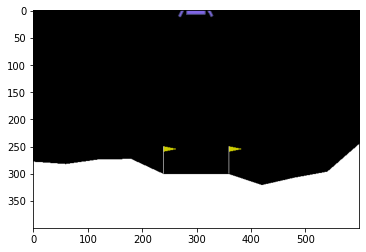

In [ ]:
obs = env.reset()
plt.imshow(env.render(mode='rgb_array'))
plt.show()

# **DQN classes definition**

In this section we are going to implement the classes needed for the training phase of all previously exposed variants.

In particular, the code is structured as follows:


* `create_model()` and `create_dueling_model()` are the methods used to create the NNs for the DQNs.

* `DQNBase` is the base class for all other classes (DQN, DDQN). It implements utility methods (such as save, load, run_training, train_batch) that are common to all implementations. DQN and DDQN inherit from DQNbase and redefine only the `get_targets_correction()` and `update_models()` methods.

* `DQN` implements the [DQN structure](https://arxiv.org/abs/1312.5602) and offers also the possibility to use an additional target model with flag `target_model=True` like exposed [here](https://www.nature.com/articles/nature14236) from DeepMind (Fixed Q-Targets)

* `DDQN` implements the [Double DQN (DDQN) structure](https://arxiv.org/abs/1509.06461)

All the classes accept as compulsory parameter the function used to build the model. This consent to switch easily from "classic" architecture to the dueling architecture (passing as parameter `create_dueling_model()`). In this way is possibible to obtain dueling architecture for DQN and DDQN classes without changing anything in the code.


In [ ]:
#LEARNING_RATE = 0.0003
#LEARNING_RATE = 0.001
LEARNING_RATE = 0.0005

#create the NN model
def create_model(lr=LEARNING_RATE):
  model = Sequential()

  model.add(InputLayer(INPUT_SHAPE))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(64, activation="relu"))
  model.add(Dense(32, activation="relu"))

  model.add(Dense(N_OUTS, activation="linear"))

  model.compile(loss="mse", optimizer=Adam(learning_rate=lr))

  #print(model.summary())

  return model

**DQNbase definition**

In [ ]:
class DQNbase:
  def __init__(self,
               create_model,
               replay_buffer_size = 100000,
               replay_buffer_mins = 128,
               episodes_max = 500,
               discount = 0.99,
               epsilon = 1,
               epsilon_min = 0.01,
               epsilon_decay = 0.9995,
               batch_size = 64,
               environment = "LunarLander-v2",
               n_actions = 4
               ):

    #constants definition
    self.replay_buffer_size = replay_buffer_size
    self.replay_buffer_mins = replay_buffer_mins
    self.episodes_max = episodes_max
    self.discount = discount #gamma

    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    self.epsilon_decay = epsilon_decay

    self.batch_size = batch_size

    self.environment = environment
    self.n_actions = n_actions
    
    #main model
    self.model = create_model()
    self.create_model = create_model

    #replay buffer
    self.replay_buffer = deque(maxlen=self.replay_buffer_size)

    
  #return trained
  def get_model(self):
    # return tf.keras.models.clone_model(self.model)
    return self.model

  #save the model in .h5
  def save(self, path):
    if path is None:
      self.model.save(self.environment + ".h5")
    else:
      self.model.save(path)

  #load the model from saved .h5
  def load(self, path="./LunarLander-v2"):
    self.model = keras.models.load_model(path)

####Utility functions####
  def get_qs(self, state):
    #(8) --> (1, 8)
    reshaped = tf.expand_dims(state, axis=0)
    return self.model.predict(reshaped)

  #e-greedy policy
  def e_greedy_action(self, state):
    if np.random.rand() < self.epsilon:
      return np.random.randint(0, self.n_actions)
    else:
      q_s = self.get_qs(state)
      return np.argmax(q_s)

  #perform the epsilon decay
  def perform_epsilon_decay(self):
    if self.epsilon > self.epsilon_min:
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

  #sample randomly from the replay buffer with certain batch_size
  #returns also batch tuple for compatibility with previous code
  def sample_buffer(self):
    
    #random batch from replay buffer
    indices = np.random.randint(low=0, high=len(self.replay_buffer), size=self.batch_size)
    batch = [self.replay_buffer[i] for i in indices]

    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []

    for el in batch:
      states.append(el[0])
      actions.append(el[1])
      rewards.append(el[2])
      next_states.append(el[3])
      dones.append(el[4])

    return batch, states, actions, rewards, next_states, dones


  #compute the corrections to apply using .fit for the model
  def get_targets_corrections(self, cs, ns, rewards, actions, dones):
    current_qs = self.model.predict_on_batch(cs)
    future_qs = self.model.predict_on_batch(ns)

    #non-optimized way
    ##################################################################################################################

    #compute target and weight update
    #i=0 #enumerate
    #new_q=0
    #targets = []
    
    #for current_state, action, reward, next_state, done in batch:
    #  if done:
    #    new_q = reward
    #  else:
        #for batch number i
    #    new_q = reward + self.discount * np.max(future_qs[i])

      #obtain qs values for this batch
    #  qs = current_qs[i]

      #update q value relative to the action done
    #  qs[action] = new_q
    #  targets.append(qs)

    #  i=i+1
    #end

    #self.model.fit(cs, np.array(targets), batch_size=self.batch_size, verbose=0)

    ###########################################################################################################

    #optimized using numpy, classic DQN
    targets = np.array(rewards) + self.discount * (np.amax(np.array(future_qs), axis=1)) * (1 - np.array(dones))
    targets_corrections = current_qs
    targets_corrections[ [i for i in range(self.batch_size)] , [np.array(actions)]] = targets

    return targets_corrections


  ###train the model with a single batch###
  def train_batch(self):
    
    #start training only if we have at least replay_buffer_mins samples
    if len(self.replay_buffer) < self.replay_buffer_mins:
        return
    
    _, current_states, actions, rewards, next_states, dones = self.sample_buffer()

    #np.squeeze needed to reduce the dimension of the np.array obtained (batch_size, 8, 1) --> (batch_size, 8)
    #See https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html
    cs = np.squeeze(np.array(current_states))
    ns = np.squeeze(np.array(next_states))

    #compute the corrections to apply
    targets_corrections = self.get_targets_corrections(cs, ns, rewards, actions, dones)

    #apply the corrections
    self.model.fit(cs, np.array(targets_corrections), batch_size=self.batch_size, verbose=0)

  #funcion needed for DQN + target model and DDQN
  #updates target model (Hard/Soft update)
  def update_models(self):
      #here is not useful
      return

  ###training algorithm###
  def run_training(self, env):
    
    #gathering training information: Reward History, Number of steps history, Mean Reward last (100|50|25) steps
    reward_history = []
    step_history = []
    mean_100h = []
    mean_50h = []
    mean_25h = []

    #training for self.episodes_max episodes
    for episode in range(1, self.episodes_max + 1):
      
      #end - start
      start = time.time()

      #gathering rewards and steps
      episode_reward = 0
      steps = 0

      #reset the environment to initial state
      current_state = env.reset()
      done=False
      
      while not done:
        #select action with e-greedy
        action = self.e_greedy_action(np.array(current_state))
        new_state, reward, done, _ = env.step(action)
        
        #get total roward for episode
        episode_reward += reward

        #add exp to replay_buffer
        transition = (current_state, action, reward, new_state, done)
        self.replay_buffer.append(transition)

        #train on a single batch
        self.train_batch()

        #update models if needed
        self.update_models()

        #perform decay
        self.perform_epsilon_decay()

        #update s to st+1
        current_state = new_state
        steps = steps+1


      #end of episode
      end = time.time() - start

      reward_history.append(episode_reward)
      step_history.append(steps)

      mean_100 = np.mean(np.array(reward_history)[-100:])
      mean_50 = np.mean(np.array(reward_history)[-50:])
      mean_25 = np.mean(np.array(reward_history)[-25:])

      mean_100h.append(mean_100)
      mean_50h.append(mean_50)
      mean_25h.append(mean_25)

      print("Episode: {:4}/{} ({:6.2f}s). TotReward: {:7.2f}.   Mean Reward (100|50|25 ep): [{:7.2f}|{:7.2f}|{:7.2f}]   Steps: {:4}.   Eps: {:1.2f}"\
          .format(episode, self.episodes_max, end, episode_reward, mean_100, mean_50, mean_25, steps, self.epsilon))
      
      #printm()
    return reward_history, mean_100h, mean_50h, mean_25h, step_history



  ###test a model###
  def test(self, env, path=None, render=False, verbose=True):
    
    if path is not None:
      self.load(path)

    for ep in range(self.episodes_max):
      state = env.reset()
      #(8) --> (1,8)
      state = tf.expand_dims(state, axis=0)
      done = False

      steps=0
      cum_reward=0
      while not done:
        
        if render:
          env.render()
        
        a = np.argmax(self.model.predict(state))
        next_state, reward, done, _ = env.step(a)
        steps = steps + 1
        cum_reward += reward
        state = tf.expand_dims(next_state, axis=0)

        if done and verbose:
            print("Episode: " + str(ep) + ", Reward: " + str(cum_reward))
            break

**DQN with target network definition**

In [ ]:
class DQN(DQNbase):
  def __init__(self,
                create_model,
                replay_buffer_size = 100000,
                replay_buffer_mins = 128,
                episodes_max = 500,
                discount = 0.99,
                epsilon = 1,
                epsilon_min = 0.01,
                epsilon_decay = 0.9995,
                batch_size = 64,
                environment = "LunarLander-v2",
                n_actions = 4,
                target_model = False):

      super().__init__(
                create_model,
                replay_buffer_size,
                replay_buffer_mins,
                episodes_max,
                discount,
                epsilon,
                epsilon_min,
                epsilon_decay,
                batch_size,
                environment,
                n_actions)
        
      #target model
      if target_model:
          self.have_target_model = True
          self.target_model = create_model()
          self.target_model.set_weights(self.model.get_weights())
          self.target_update_counter = 0
          self.target_update_frequency = 100
      else:
          self.have_target_model = False
    
  #load the model
  def load(self, path="./LunarLander-v2.h5"):
    self.model = tf.keras.models.load_model(path)

    if self.have_target_model:
        self.target_model = tf.keras.models.load_model(path)

  #corrections definition
  def get_targets_corrections(self, cs, ns, rewards, actions, dones):
    current_qs = self.model.predict_on_batch(cs)
    
    if not self.have_target_model:
      future_qs = self.model.predict_on_batch(ns)
    else:
      future_qs = self.target_model.predict_on_batch(ns)

    #np-optimized version to compute target for the update
    targets = np.array(rewards) + self.discount * (np.amax(np.array(future_qs), axis=1)) * (1 - np.array(dones))
    targets_corrections = current_qs
    targets_corrections[ [i for i in range(self.batch_size)] , [np.array(actions)]] = targets

    return targets_corrections


  def update_models(self):
    if self.have_target_model:
        self.target_update_counter += 1

        if self.target_update_counter >= self.target_update_frequency:
           self.target_model.set_weights(self.model.get_weights())       
           self.target_update_counter = 0


**DDQN definition**

In [ ]:
class DDQN(DQNbase):
    def __init__(self, 
                create_model,
                replay_buffer_size = 100000,
                replay_buffer_mins = 128,
                episodes_max = 500,
                discount = 0.99,
                epsilon = 1,
                epsilon_min = 0.01,
                epsilon_decay = 0.9995,
                batch_size = 64,
                environment = "LunarLander-v2",
                n_actions = 4,
                soft_update=False,
                tau=0.1):


      super().__init__(
                    create_model, 
                    replay_buffer_size,
                    replay_buffer_mins,
                    episodes_max,
                    discount,
                    epsilon,
                    epsilon_min,
                    epsilon_decay,
                    batch_size,
                    environment,
                    n_actions)

      #for soft update
      self.soft_update = soft_update
      self.tau = 0.1 #experimental

      #target model
      self.target_model = create_model()
      self.target_model.set_weights(self.model.get_weights())
      self.target_update_counter = 0
      self.target_update_frequency = 100
    
    
    def load(path):
        self.model = keras.models.load_model(path)
        self.target_model = keras.models.load_model(path)

    #corrections definition
    def get_targets_corrections(self, cs, ns, rewards, actions, dones):

      #ddqn target
      #model-->qmodel
      qmodel_qs = self.model.predict_on_batch(cs)
      qmodel_max_actions = np.argmax(self.model.predict_on_batch(ns), axis=1)

      #(64,4)
      tmodel_qs = self.target_model.predict_on_batch(ns)
      
      #array, indexes to take --> equivalent to tmodel_qs[i][qmodel_max_actions[i]]
      #for each row, give me the q-value of the previous computed max-action(s)
      #https://numpy.org/doc/stable/reference/generated/numpy.take.html
      tmodel_qs_update = np.array([ np.take(tmodel_qs[i], qmodel_max_actions[i]) for i in range(self.batch_size) ])
      #tmodel_qs_update = tmodel_qs[qmodel_max_actions]

      #compute target for the update
      targets = np.array(rewards) + self.discount * tmodel_qs_update * (1 - np.array(dones))
      targets_corrections = qmodel_qs
      targets_corrections[ [i for i in range(self.batch_size)] , [np.array(actions)]] = targets

      return targets_corrections
    
    
    #update the models
    def update_models(self):
        self.target_update_counter += 1

        if self.target_update_counter >= self.target_update_frequency:
          self.target_update_counter = 0

          if self.soft_update:
            new_weights = self.target_model.get_weights()
            
            #0 qmodel, 1 tmodel
            for i, qw_tw in enumerate(zip(self.model.get_weights(), self.target_model.get_weights())):
              new_weights[i] = qw_tw[1] * (1 - self.tau) + qw_tw[0] * self.tau

            self.target_model.set_weights(new_weights)
          
          else:  
            self.target_model.set_weights(self.model.get_weights())       
            

**Dueling Networks NN, we change only the model**

In [ ]:
num_actions = N_OUTS

#definition of a dueling architecture
def create_dueling_model(lr=LEARNING_RATE):
  input = Input(shape=(INPUT_SHAPE))
  
  layer = input
  layer = Dense(128, activation="relu", input_shape=INPUT_SHAPE)(layer)
  layer = Dense(64, activation="relu")(layer)
  layer = Dense(32, activation="relu")(layer)

  #v_s for current state
  v_s = Dense(1)(layer)

  #advantages
  advantage = Dense(num_actions)(layer)

  #qvalues --> Q(S_t, a_t) = v(s_t) + ( A(s_t, a) - mean(A(s_t, a) )
  #np.mean(advantage, axis=1, keepdims=True) or tf.math.reduce_mean(advantage, axis=1, keepdims=True)
  #keepdims=True retains reduced dimensions with length 1, https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
  layer = ( v_s + (advantage - tf.math.reduce_mean(advantage, axis=1, keepdims=True)) )

  dueling_model = Model(inputs=input, outputs=layer)
  dueling_model.compile(loss="mse", optimizer=Adam(learning_rate=lr))
  
  return dueling_model

# **Testing DQN**

Here we train and test the models (for 500 epochs each). The episodes maximum was temporarly fixed to 5 only to show the outputs of the methods and to clean up the notebook.

In [ ]:
TEMPORARY_MAX=5 #500
#path = '/content/drive/MyDrive/AAS_project/'
path = '/content'

In [ ]:
def export_routine(name, model, rh, m100, m50, sh, path):
  s = path + "/" + name + "_" + str(TEMPORARY_MAX) + "ep.h5"

  df = pd.DataFrame()
  df['rh'] = rh
  df['m100'] = m100
  df['m50'] = m50
  df['sh'] = sh

  df.to_csv(path + "/" + name + "_" + str(TEMPORARY_MAX) + "_logs.csv")

  model.save(s)

In [ ]:
dqn = DQN(create_model=create_model, episodes_max=TEMPORARY_MAX)
rh, m100, m50, _, sh = dqn.run_training(env)

export_routine(name="dqn", model=dqn, rh=rh, m100=m100, m50=m50, sh=sh, path=path)

Episode:    1/5 (  0.20s). TotReward: -303.25.   Mean Reward (100|50|25 ep): [-303.25|-303.25|-303.25]   Steps:   82.   Eps: 0.96
Episode:    2/5 (  3.33s). TotReward: -175.07.   Mean Reward (100|50|25 ep): [-239.16|-239.16|-239.16]   Steps:  108.   Eps: 0.91
Episode:    3/5 (  2.73s). TotReward:  -92.74.   Mean Reward (100|50|25 ep): [-190.35|-190.35|-190.35]   Steps:   62.   Eps: 0.88
Episode:    4/5 (  4.55s). TotReward: -244.36.   Mean Reward (100|50|25 ep): [-203.85|-203.85|-203.85]   Steps:  102.   Eps: 0.84
Episode:    5/5 (  3.37s). TotReward: -298.64.   Mean Reward (100|50|25 ep): [-222.81|-222.81|-222.81]   Steps:   77.   Eps: 0.81


**Testing DQN + target model**

In [ ]:
dqn = DQN(target_model=True, create_model=create_model, episodes_max=TEMPORARY_MAX)
rh, m100, m50, _, sh = dqn.run_training(env)

export_routine("dqn_target", model=dqn, rh=rh, m100=m100, m50=m50, sh=sh, path=path)

Episode:    1/5 (  0.02s). TotReward: -142.36.   Mean Reward (100|50|25 ep): [-142.36|-142.36|-142.36]   Steps:   95.   Eps: 0.95
Episode:    2/5 (  4.28s). TotReward: -276.37.   Mean Reward (100|50|25 ep): [-209.36|-209.36|-209.36]   Steps:  118.   Eps: 0.90
Episode:    3/5 (  5.76s). TotReward: -113.62.   Mean Reward (100|50|25 ep): [-177.45|-177.45|-177.45]   Steps:  128.   Eps: 0.84
Episode:    4/5 (  3.94s). TotReward: -252.20.   Mean Reward (100|50|25 ep): [-196.14|-196.14|-196.14]   Steps:   86.   Eps: 0.81
Episode:    5/5 (  5.82s). TotReward: -498.35.   Mean Reward (100|50|25 ep): [-256.58|-256.58|-256.58]   Steps:  115.   Eps: 0.76


**Testing DDQN**

In [ ]:
dqn = DDQN(soft_update=False, create_model=create_model, episodes_max=TEMPORARY_MAX)
rh, m100, m50, _, sh = dqn.run_training(env)

export_routine("ddqn", model=dqn, rh=rh, m100=m100, m50=m50, sh=sh, path=path)

Episode:    1/5 (  0.27s). TotReward: -431.15.   Mean Reward (100|50|25 ep): [-431.15|-431.15|-431.15]   Steps:  119.   Eps: 0.94
Episode:    2/5 (  5.79s). TotReward: -460.75.   Mean Reward (100|50|25 ep): [-445.95|-445.95|-445.95]   Steps:   90.   Eps: 0.90
Episode:    3/5 (  3.85s). TotReward:  -80.59.   Mean Reward (100|50|25 ep): [-324.16|-324.16|-324.16]   Steps:   84.   Eps: 0.86
Episode:    4/5 (  4.60s). TotReward: -375.96.   Mean Reward (100|50|25 ep): [-337.11|-337.11|-337.11]   Steps:   93.   Eps: 0.82
Episode:    5/5 (  4.42s). TotReward: -409.38.   Mean Reward (100|50|25 ep): [-351.56|-351.56|-351.56]   Steps:   89.   Eps: 0.79


In [ ]:
dqn = DDQN(soft_update=True, create_model=create_model, episodes_max=TEMPORARY_MAX)
rh, m100, m50, _, sh = dqn.run_training(env)

export_routine("ddqn", model=dqn, rh=rh, m100=m100, m50=m50, sh=sh, path=path)

**Dueling DQN**

In [ ]:
dqn = DQN(create_model=create_dueling_model, episodes_max=TEMPORARY_MAX)
rh, m100, m50, _, sh = dqn.run_training(env)

export_routine("dueling_dqn", model=dqn, rh=rh, m100=m100, m50=m50, sh=sh, path=path)

Episode:    1/5 (  0.16s). TotReward:    9.04.   Mean Reward (100|50|25 ep): [   9.04|   9.04|   9.04]   Steps:   89.   Eps: 0.96
Episode:    2/5 (  3.31s). TotReward: -135.05.   Mean Reward (100|50|25 ep): [ -63.01| -63.01| -63.01]   Steps:  108.   Eps: 0.91
Episode:    3/5 (  3.66s). TotReward:  -64.17.   Mean Reward (100|50|25 ep): [ -63.39| -63.39| -63.39]   Steps:   83.   Eps: 0.87
Episode:    4/5 (  4.47s). TotReward: -143.20.   Mean Reward (100|50|25 ep): [ -83.34| -83.34| -83.34]   Steps:   99.   Eps: 0.83
Episode:    5/5 (  6.00s). TotReward: -221.67.   Mean Reward (100|50|25 ep): [-111.01|-111.01|-111.01]   Steps:  117.   Eps: 0.78


**Dueling Double DQN (D3QN)**

In [ ]:
dqn = DDQN(soft_update=False, create_model=create_dueling_model, episodes_max=TEMPORARY_MAX)
rh, m100, m50, _, sh = dqn.run_training(env)

export_routine("d3qn", model=dqn, rh=rh, m100=m100, m50=m50, sh=sh, path=path)

Episode:    1/5 (  0.10s). TotReward: -346.76.   Mean Reward (100|50|25 ep): [-346.76|-346.76|-346.76]   Steps:   95.   Eps: 0.95
Episode:    2/5 (  2.75s). TotReward: -132.40.   Mean Reward (100|50|25 ep): [-239.58|-239.58|-239.58]   Steps:   80.   Eps: 0.92
Episode:    3/5 (  2.61s). TotReward: -170.10.   Mean Reward (100|50|25 ep): [-216.42|-216.42|-216.42]   Steps:   60.   Eps: 0.89
Episode:    4/5 (  5.90s). TotReward: -284.92.   Mean Reward (100|50|25 ep): [-233.55|-233.55|-233.55]   Steps:  120.   Eps: 0.84
Episode:    5/5 (  7.78s). TotReward: -258.37.   Mean Reward (100|50|25 ep): [-238.51|-238.51|-238.51]   Steps:  151.   Eps: 0.78


**Testing model**

In [ ]:
dqn = DQN(create_model=create_model, episodes_max=TEMPORARY_MAX)
dqn.test(env, path="/content/drive/MyDrive/AAS_project/results/d3qn_500ep.h5", render=False)

Episode: 0, Reward: 309.08336087213434
Episode: 1, Reward: 273.5187061761542
Episode: 2, Reward: 300.4747033970141
Episode: 3, Reward: 289.22167482668885
Episode: 4, Reward: 249.89779886393075


# **Conclusion**

Concluding, the results of all the experiments done are reported below (trained network + logs). The logs are .csv files that contain the reward history, the mean reward history for (100|50) last episodes and the steps per episode history. The .h5 files represent the trained and serialized network.

You can download everything [here](https://drive.google.com/drive/folders/1uvXgLfkg-DP0Olj2bo8ToPh_u5lXKR3A?usp=sharing).

The mean reward over the last 100 episodes are reported. All models were trained for 500 episodes:
* **DQN**: 253.74
* **DQN + target network**: 254.50
* **DDQN**: 237.42
* **DDQN with soft update**: 144.97
* **Dueling DQN**: 238.49
* **D3QN**: 270.73

Concluding, two small videos to show the evolution of the models (here reported for DQN):
* [early episodes](https://drive.google.com/file/d/1y9Qd_jo49qWvcBn8de9AH1HlBtqfTKpU/view?usp=sharing)
* [last episode](https://drive.google.com/file/d/1XZWd7AKM4tr9R372mq-iOLWAROaKO-3E/view?usp=sharing)




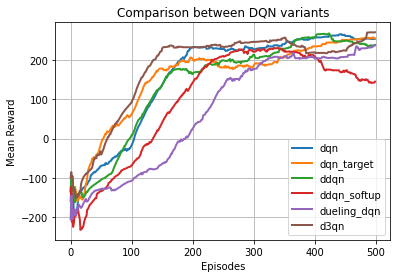

# **References**

Below I have reported a non exhaustive list of sources from which I was inspired for the project.

Papers:
* [DQN](https://arxiv.org/abs/1312.5602)
* [DQN with target network (Fixed Q-Targets)](https://www.nature.com/articles/nature14236)
* [Double DQN (DDQN)](https://arxiv.org/abs/1509.06461)
* [Dueling DQN](https://arxiv.org/abs/1511.06581)
* [Dueling Double DQN (D3QN)](https://ieeexplore.ieee.org/document/8483478)
* [Rainbow paper](https://arxiv.org/abs/1710.02298)


Articles, tutorials and repository I consulted:
* https://medium.com/@parsa_h_m/deep-reinforcement-learning-dqn-double-dqn-dueling-dqn-noisy-dqn-and-dqn-with-prioritized-551f621a9823
* https://github.com/Kaixhin/Rainbow
* https://pylessons.com/CartPole-DDDQN/
* https://www.researchgate.net/figure/DQN-hyperparameters-on-Lunar-Lander-Hyperparameters-marked-with-a-are-used-only-for_tbl2_340094887
* https://eulertech.wordpress.com/2018/01/02/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-network/
* https://medium.com/@gtnjuvin/my-journey-into-deep-q-learning-with-keras-and-gym-3e779cc12762
* https://towardsdatascience.com/getting-an-ai-to-play-atari-pong-with-deep-reinforcement-learning-47b0c56e78ae
* https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c
* https://github.com/pythonlessons/Reinforcement_Learning
* https://medium.com/@qempsil0914/deep-q-learning-part2-double-deep-q-network-double-dqn-b8fc9212bbb2
* https://pythonprogramming.net/deep-q-learning-dqn-reinforcement-learning-python-tutorial/
* https://cugtyt.github.io/blog/rl-notes/201807201658.html
* https://zhuanlan.zhihu.com/p/365109764 (chinese)
* https://cugtyt.github.io/blog/rl-notes/201807201658.html

